<a href="https://colab.research.google.com/github/dev-Adward/RNN-Study/blob/master/ethereum_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
raw_data = pd.read_csv('ether.csv')
data = raw_data[["날짜", "시가", "종가", "고가", "저가", "거래량"]]
data = data.sort_values(by="날짜", ascending=True)
data.reset_index(drop=True, inplace=True)

sampled_data = data.iloc[::100]  # 간격을 10으로 설정하여 샘플링
print(data)

                날짜        시가        종가        고가        저가      거래량
0     2016- 03- 10     11.20     11.75     11.85     11.07    0.00K
1     2016- 03- 11     11.75     11.95     11.95     11.75    0.18K
2     2016- 03- 12     11.95     12.92     13.45     11.95    0.83K
3     2016- 03- 13     12.92     15.07     15.07     12.92    1.30K
4     2016- 03- 14     15.07     12.50     15.07     11.40   92.18K
...            ...       ...       ...       ...       ...      ...
2769  2023- 10- 09  1,632.85  1,579.74  1,635.13  1,550.10  372.11K
2770  2023- 10- 10  1,579.77  1,567.60  1,593.73  1,552.34  255.41K
2771  2023- 10- 11  1,567.62  1,566.88  1,578.16  1,549.16  279.01K
2772  2023- 10- 12  1,566.88  1,539.70  1,568.47  1,523.78  260.59K
2773  2023- 10- 13  1,539.70  1,541.98  1,546.50  1,538.18  259.62K

[2774 rows x 6 columns]


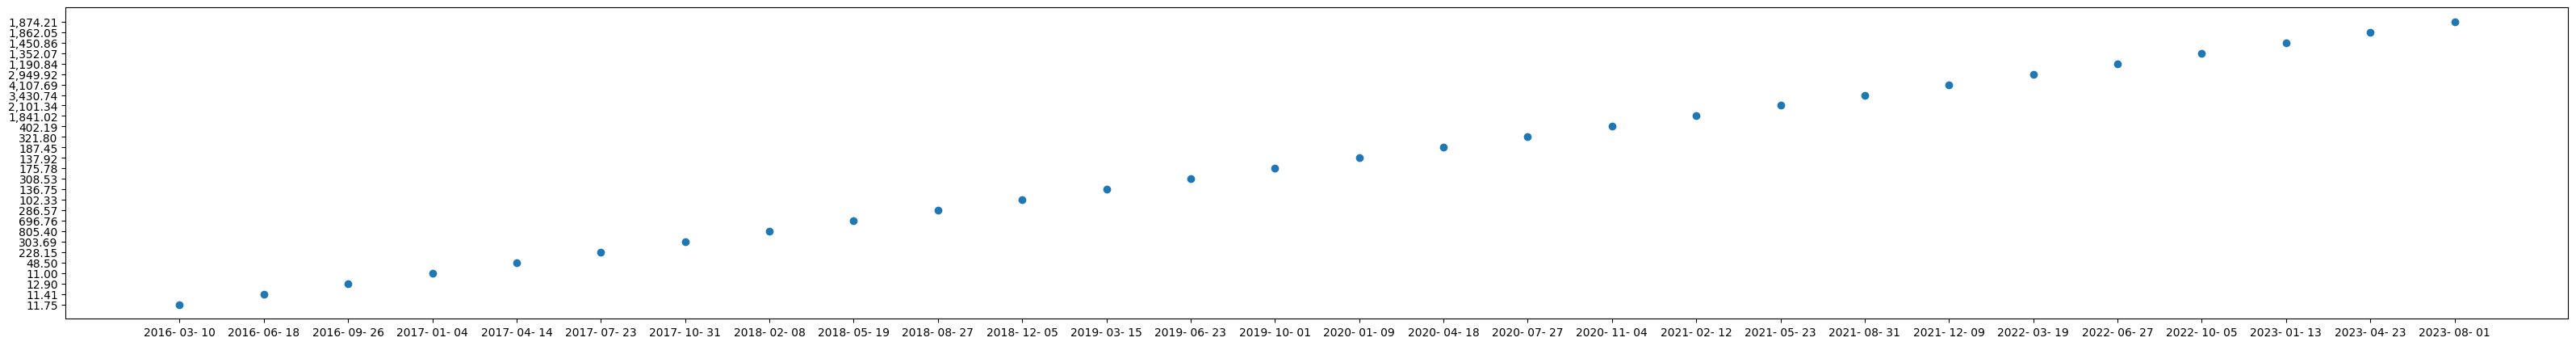

In [ ]:
plt.figure(figsize=(40,5))
plt.scatter(sampled_data["날짜"], sampled_data["종가"])

In [19]:
# Min-Max 스케일링
columns_to_clean = ['시가', '종가', '고가', '저가']

for column in columns_to_clean:
    data[column] = data[column].str.replace(',', '')


scaler = MinMaxScaler()
additional_features = data[[ "시가", "고가", "저가", "종가"]].values

real_price_normalized = scaler.fit_transform(additional_features.reshape(-1, 1))
real_price_normalized = real_price_normalized.reshape(-1, len(columns_to_clean))
# Concatenate 'real_price_normalized' and additional features
X = np.hstack((real_price_normalized, additional_features))

# Prepare X and y
sequence_length = 10
X_data, y_data = [], []
for i in range(len(X) - sequence_length):
    X_data.append(X[i:i+sequence_length])
    y_data.append(X[i+sequence_length][0])  # Considering '종가' as the target

X_data = np.array(X_data)
y_data = np.array(y_data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)


# LSTM model with additional features
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, X_data.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# 목표 변수(y)의 형태 확인 및 수정
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# 디버깅을 위해 데이터 모양과 데이터 유형 출력
print("X_train 모양:", X_train.shape, "데이터 유형:", X_train.dtype)
print("y_train 모양:", y_train.shape, "데이터 유형:", y_train.dtype)
print("X_test 모양:", X_test.shape, "데이터 유형:", X_test.dtype)
print("y_test 모양:", y_test.shape, "데이터 유형:", y_test.dtype)

# 데이터 형 변환 (float32)
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

# 모델 훈련
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

X_train 모양: (2211, 10, 8) 데이터 유형: object
y_train 모양: (2211, 1) 데이터 유형: float64
X_test 모양: (553, 10, 8) 데이터 유형: object
y_test 모양: (553, 1) 데이터 유형: float64
Epoch 1/100
70/70 [==============================] - 3s 12ms/step - loss: 717.8813 - val_loss: 5.1729
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 23.2299 - val_loss: 18.7723
Epoch 3/100
70/70 [==============================] - 1s 9ms/step - loss: 30.0740 - val_loss: 2.8882
Epoch 4/100
70/70 [==============================] - 1s 8ms/step - loss: 42.6332 - val_loss: 5.7325
Epoch 5/100
70/70 [==============================] - 1s 9ms/step - loss: 7.0622 - val_loss: 2.5561
Epoch 6/100
70/70 [==============================] - 1s 9ms/step - loss: 3.5537 - val_loss: 28.7863
Epoch 7/100
70/70 [==============================] - 1s 8ms/step - loss: 14.4295 - val_loss: 0.5442
Epoch 8/100
70/70 [==============================] - 1s 9ms/step - loss: 32.8186 - val_loss: 332.8850
Epoch 9/100
70/70 [=======================

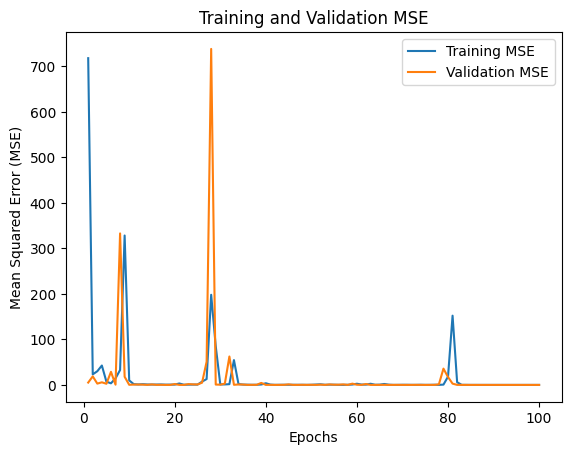

In [20]:
# Get the MSE for each epoch
train_mse = history.history['loss']
val_mse = history.history['val_loss']

# Plot the MSE
plt.plot(range(1, 100+1), train_mse, label='Training MSE')
plt.plot(range(1, 100+1), val_mse, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation MSE')
plt.legend()
plt.show()

18/18 [==============================] - 0s 6ms/step
(553, 1)


<ipython-input-22-cfa5c3d55e8d>:26: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  plt.tight_layout()
<ipython-input-22-cfa5c3d55e8d>:26: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


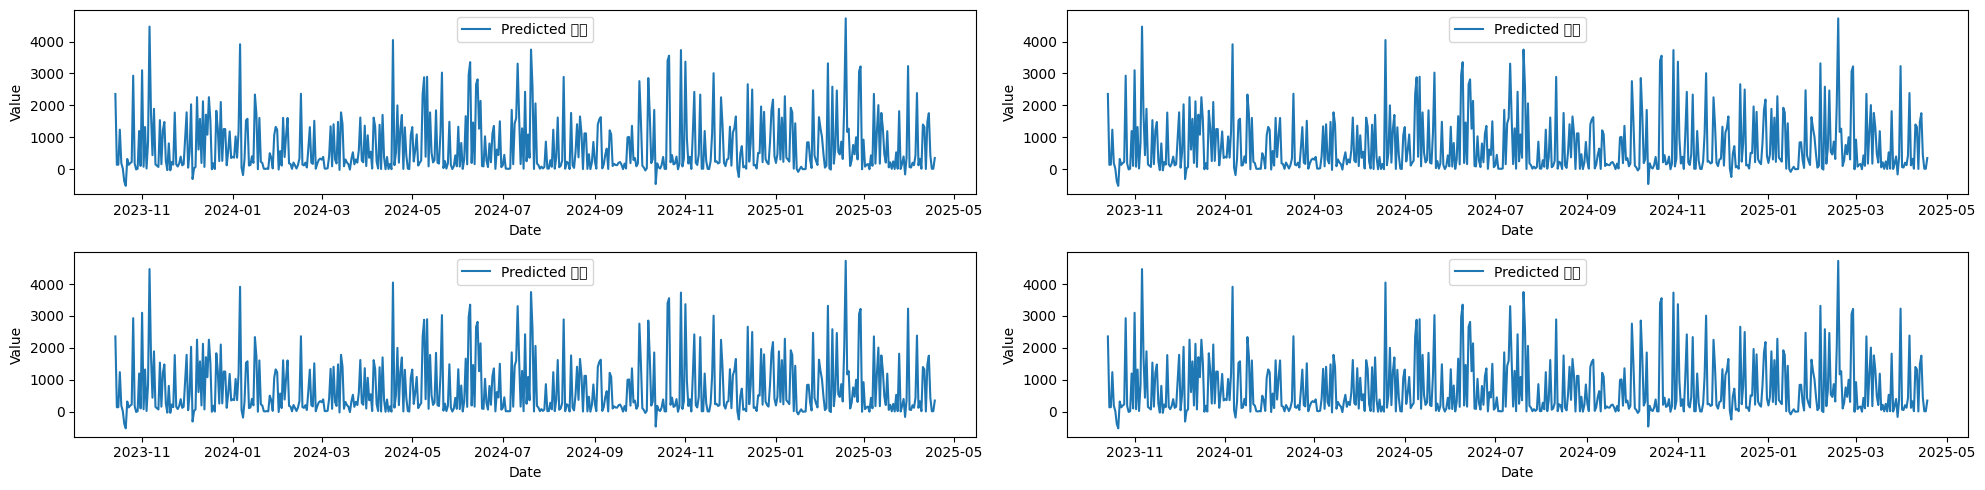

In [22]:
last_date = pd.to_datetime(data["날짜"].iloc[-1])
# 모델을 사용하여 예측
predictions = model.predict(X_test)
print(predictions.shape)

# 예측값을 역으로 변환 (MinMax 스케일링의 역변환)
predictions_original_scale = scaler.inverse_transform(predictions)

# predictions_original_scale을 2D 배열로 변환
predictions_original_scale = predictions_original_scale.reshape(-1, 1)

# 예측된 날짜 생성
predicted_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=len(predictions), freq='D')

# 예측 결과 시각화
plt.figure(figsize=(20, 5))

# 각 종속 변수에 대한 예측값 시각화
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(predicted_dates, predictions_original_scale[:, 0], label=f'Predicted {columns_to_clean[0]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()

plt.tight_layout()
plt.show()